# Final Project: Vehicle Rounting Problem

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
import copy
import random
import timeit

## 1. Import, Data Investigation and Preprocessing

In [2]:
# VRP1
# import distance matrix
filepath = 'VRP1/distance.txt'
with open(filepath, 'r') as t:
    distance_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        distance_matrix.append(y)
        
    t.close()
    distance_matrix = np.array(distance_matrix)

# import demand matrix
filepath = 'VRP1/demand.txt'
with open(filepath, 'r') as t:
    demand_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        demand_matrix.append(y)
        
    t.close()
    demand_matrix = np.array(demand_matrix)
    demand_matrix = demand_matrix[0]
    # since demand matrix has length 100 but the distance_matrix has length 101, we add one demand with 0 to represent the depot 
    demand_matrix = np.insert(demand_matrix,0,0)

# import capacity matrix
filepath = 'VRP1/capacity.txt'
with open(filepath, 'r') as t:
    capacity_matrix = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        capacity_matrix.append(y)
        
    t.close()
    capacity_matrix = np.array(capacity_matrix)
    capacity_matrix = capacity_matrix[0]

# import transportation_cost matrix
filepath = 'VRP1/transportation_cost.txt'
with open(filepath, 'r') as t:
    transportation_cost = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        transportation_cost.append(y)
        
    t.close()
    transportation_cost = np.array(transportation_cost)
    transportation_cost = transportation_cost[0]

# VRP2

# import distance matrix
filepath = 'VRP2/distance.txt'
with open(filepath, 'r') as t:
    distance_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        distance_matrix_2.append(y)
        
    t.close()
    distance_matrix_2 = np.array(distance_matrix_2)

# import demand matrix
filepath = 'VRP2/demand.txt'
with open(filepath, 'r') as t:
    demand_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        demand_matrix_2.append(y)
        
    t.close()
    demand_matrix_2 = np.array(demand_matrix_2)
    demand_matrix_2 = demand_matrix_2[0]
    # since demand matrix has length 100 but the distance_matrix has length 101, we add one demand with 0 to represent the depot 
    demand_matrix_2 = np.insert(demand_matrix_2,0,0)

    
# import capacity matrix
filepath = 'VRP2/capacity.txt'
with open(filepath, 'r') as t:
    capacity_matrix_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        capacity_matrix_2.append(y)
        
    t.close()
    capacity_matrix_2 = np.array(capacity_matrix_2)
    capacity_matrix_2 = capacity_matrix_2[0]
    

    
# import transportation_cost matrix
filepath = 'VRP2/transportation_cost.txt'
with open(filepath, 'r') as t:
    transportation_cost_2 = []
    for line in t.readlines():
        y = [int(value) for value in line.split()]
        transportation_cost_2.append(y)
        
    t.close()
    transportation_cost_2 = np.array(transportation_cost_2)
    transportation_cost_2 = transportation_cost_2[0]

In [3]:
# information about the distance matrix for VRP1
print("Information about distance matric for VRP1 \n# columns: ", len(distance_matrix[0]))
print("# lines: ", len(distance_matrix))
asymmetric = (distance_matrix != np.transpose(distance_matrix))
print(np.unique(asymmetric))
print("Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric. \n")

# information about the distance matrix for VRP2
print("Information about distance matric for VRP2 \n# columns: ", len(distance_matrix_2[0]))
print("# lines: ", len(distance_matrix_2))
asymmetric_2 = (distance_matrix_2 != np.transpose(distance_matrix_2))
                
print(np.unique(asymmetric_2))
print("Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric.")

Information about distance matric for VRP1 
# columns:  101
# lines:  101
[False  True]
Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric. 

Information about distance matric for VRP2 
# columns:  101
# lines:  101
[False  True]
Since we also get False values while comparing the matrix with its transposed, the matrix is asymmetric.


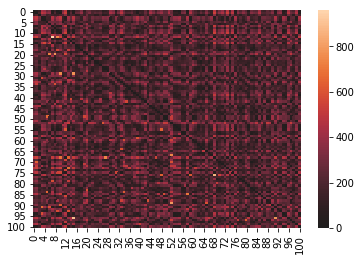

In [4]:
#heatmap
ax = sns.heatmap(distance_matrix, center=0)

The heatmap again illustrates the fact that we have to deal with an asymmetric distance matrix. This property is realistic if we think about for example, one-way roads. Going from A to B does not strictly have to have the same distance than going from B to A. 

We further notice that we deal with a matrix that does note fulfill the triangle inequality, i.e. the distance from going from A to B has to be always smaller or equal than going from A to B over a third point C. This is not the case in the given distance matrices. This has the consequence that we cannot apply the k-means algorithm since a representation in a cartesian coordinate system is not uniquely possible. 

Our assumption is that the matrix consists of Manhatten distances.

## 2. Heuristic

The initial situation of the Vehicle Routing Problem (VRP) is that we are given a distance matrix, a capacity matrix, a demand matrix and a transportation cost matrix. The aim is to design a route with minimal costs. In order to set up an initial solution, which we then later want to optimize, we deal with the following heuristic: 

1. Take the capacity matrix and randomly pick a car from this list. Remove the entry from the capacity matrix.
2. Start with the customer that is farthest away from the depot and add it to our car. 
3. Keep adding customers to the car, as long as the car still has the capacity to fulfill the customer's demand. Now always take the customer that is closest.
4. Stop filling the car when one customer does not fit into the car anymore. Start with 1 again until every customer's demand is fulfilled or we do not have any cars left.  

### 2.1 Helper functions

In [5]:
# find the customer which is closest to another given customer
def find_closest_customer(last_customer_visited, customer_indices,distance_matrix):
    distance_list = []
    for i in customer_indices:
        if i == last_customer_visited:
            # set the distance to customer's own position very high in order for it not the be chosen as the closest customer
            distance_list.append(max(distance_matrix[last_customer_visited]))
        else: 
            distance_list.append(distance_matrix[i][last_customer_visited])
    

    index = distance_list.index(min(distance_list))
    customer_index = customer_indices[index]
    return customer_index      

In [6]:
def total_demand_satisfied(route,demand_matrix):
    total_demand_satisfied = 0
    for i in route:
        total_demand_satisfied += demand_matrix[i]
    return total_demand_satisfied

In [7]:
# randomly pick a car from capacity matrix and return its capacity

def pick_random_car(capacity_matrix):
    car_type = random.randrange(len(capacity_matrix))
    cluster_size = capacity_matrix[car_type]
    return cluster_size

In [8]:
def get_cost_list(cars_used):
    unique_capacity = sorted(set(capacity_matrix)) #VRP1: 100, 300, 500, 1000
    unique_cost = sorted(set(transportation_cost)) #VRP1: 11, 13, 15, 18

    cars_costs = dict(zip(unique_capacity, unique_cost))
    cost_list = [cars_costs.get(value) for value in cars_used]
    return cost_list

### 2.2 Cluster initialization

In [9]:
def cluster_initialization_with_random_cars(demand_matrix,distance_matrix,capacity_matrix):
    clusters = []
    cars_used = []

    customers = copy.deepcopy(demand_matrix)
    capacity = list(copy.deepcopy(capacity_matrix))
    customer_indices = list(range(len(demand_matrix))[1:])

    # keep on creating clusters as long as customers are not satisfied    
    while any(item != 0 for item in customers):
        
        # determine cluster size by randomly pick a car
        cluster_size = pick_random_car(capacity)
        
        # append capacity_size to the list of cars being used
        cars_used.append(cluster_size)
        
        # remove capacity that has been used from the capacity_matrix
        capacity.remove(cluster_size)
        
        if cluster_size not in [100,300,500,1000]:
            car_capacity = capacity_matrix[random.randrange(len(capacity_matrix))]
        else:
            car_capacity = cluster_size

        visited_customers = []

        # keep adding customers as long as capacities are not full
        while car_capacity > 0 and any(item != 0 for item in customers):
            
            # for the starting customer of each car, choose the customer that is farthest away from the depot
            if visited_customers == []:
                max_distance = -1
                max_distance_index = -1
                
                for index in customer_indices:
                    new_distance = distance_matrix[0][index]
                    if new_distance > max_distance:
                        max_distance = new_distance
                        max_distance_index = index
                    
                next_customer = max_distance_index
            # else append everytime the nearest customer
            else:
                last_customer = visited_customers[-1]
                next_customer = find_closest_customer(last_customer,customer_indices,distance_matrix)

            # after choosing next customer only merge if demand is completely covered
            if customers[next_customer] <= car_capacity:
                visited_customers.append(next_customer)
                
                # reduce the capacity by the customer demand
                car_capacity -= customers[next_customer]

                # demand of the customer is fully satsified
                customers[next_customer] = 0
                
                # delete visited customers
                del customer_indices[customer_indices.index(next_customer)]
            else:
                car_capacity = 0

        # create and add this car object to our current solution        
        clusters.append([0]+visited_customers+[0])

    return clusters, cars_used

## 3. Genetic Algorithm

The nature inspired algorithm we use is the genetic algorithm. We want to apply it to our initialized clusters in order to optimize the route of the single cars. To be able to apply the genetic algorithm, we have to create a population (of possible routes a truck could take). Therefore we randomly create permutations of the initialzed clusters. How many permutations of one cluster shall be created, can be set by the parameter population_size.   

In [10]:
# get route and shuffle

def shuffle_cluster(cluster): 
    sliced_cluster = []
    sliced_cluster = cluster[1:len(cluster)-1]
    random.shuffle(sliced_cluster)
    sliced_cluster.append(0)
    sliced_cluster.insert(0,0)    
    return list(sliced_cluster)  

In [11]:
# create as many permutations as given with population_size. It returns a list in which every route is randomly
# shuffled n-times with n being the population size. 

def create_permutations(initialized_clusters, population_size):
    population_list = []
    sliced_shuffled = []
    
    for i in range(len(initialized_clusters)):
        
        for j in range((population_size)):
            sliced_shuffled = shuffle_cluster(initialized_clusters[i])
            if sliced_shuffled not in population_list:
                population_list.append(sliced_shuffled)
            else: 
                for k in range (20):
                    sliced_shuffled = shuffle_cluster(initialized_clusters[i])
                    if sliced_shuffled not in population_list:
                        population_list.append(sliced_shuffled)
                        break
                    else: 
                        if k == 19: 
                            population_list.append(sliced_shuffled)
                        
                        
    return population_list

### 3.1 Evaluate Fitness

Here the fitness of one cluster corresponds to the costs. Since we want to minimize our costs, a low evaluation value represents a high fitness. 

In [12]:
# helper function to get the total distance of one single cluster

def total_distance_cluster(cluster):
    total_distance = 0
    
    for i in range(len(cluster)-1):
        total_cluster_distance = total_distance + distance_matrix[cluster[i]][cluster[i+1]]
        total_distance = total_cluster_distance
    return total_distance

In [13]:
# evaluate one single cluster

def evaluate_cluster(transportation_cost,distance_matrix,cluster):
    total_distance = 0
    
    for i in range(len(cluster)-1):
        total_cluster_distance = total_distance + distance_matrix[cluster[i]][cluster[i+1]]
        total_distance = total_cluster_distance
    return transportation_cost * total_distance

In [14]:
# evaluate a list of clusters, i.e. one whole solution

def final_evaluation(list_of_clusters,cost_list):
    total_cost = 0 
    for i in range(len(list_of_clusters)):
        current_cluster = list_of_clusters[i]
        total_cost = total_cost + cost_list[i]*total_distance_cluster(current_cluster)
    return total_cost

### 3.2 Selection

The selection method we use is called tournament selection. It also takes the population (here: population_list), its fitness array and the mating pool size (how many chromosomes do we want to keep) as input. It basically takes the chromosomes that have the lowest cost values. Note that highest fitness level corresponds to lowest cost values in this example since our aim is to minimize the overall costs.

In [15]:
def tournament_selection(population_list, mating_pool_size,population_size,cost_list):
    mating_pool_big = []
    counter = 0
    for i in range(len(population_list)):
        if i % population_size == 0: 
            current_population = population_list[i:i+population_size]
            mating_pool = []
            cost = cost_list[counter]
            counter +=1 
            j = 0
            
            for j in range(mating_pool_size):
                participant1 = current_population[random.randint(0, population_size-1)]
                participant2 = current_population[random.randint(0, population_size-1)]
                
                if (participant1 != participant2):
                    j +=1
                    if evaluate_cluster(cost, distance_matrix, participant1) <= evaluate_cluster(cost, distance_matrix, participant2) :
                        mating_pool = mating_pool + [participant1]
                    else: 
                        mating_pool = mating_pool + [participant2]  
                else: 
                    mating_pool = mating_pool + [participant1] 
                    

            mating_pool_big = mating_pool_big + mating_pool 
    return mating_pool_big

### 3.3 Recombination

 

In recombination, two chromosomes are taken, called parent1 and parent2, and they are recombined (have children, here: child1 and child2) that might produce better outputs, i.e. lower cost.

In uniform_order_based_crossover, we use a template to create valid children that still visit every customer on the route.

In [16]:
def uniform_order_based_crossover(parent1,parent2):
    parent1 = parent1[1:-1]
    parent2 = parent2[1:-1]
    
    table = np.zeros(len(parent1))
    for i in range(len(parent1)):
        table[i]= random.randint(0,1)
    
    child1 = np.zeros(len(parent1))
    child2 = np.zeros(len(parent1))
    for i in range(len(table)):
        if table[i]==1:
            child1[i]=parent1[i]
            child2[i]=parent2[i]
        
    for i in range(len(table)):
        if child1[i]==0:
            for j in range(len(parent2)):
                if parent2[j] not in child1:
                    child1[i] = parent2[j]
                    break
        
        if child2[i]==0:
            for j in range(len(parent1)):
                if parent1[j] not in child2:
                    child2[i] = parent1[j]
                    break
                    
                
    child1 = np.insert(child1,0,0)
    child1 = np.insert(child1, len(child1),0)
    child2 = np.insert(child2,0,0)
    child2 = np.insert(child2, len(child2),0)
                    
    return child1, child2  

In [17]:
def recombine_uniform_order_based_crossover(population_size,mating_pool,crossover_probability, mating_pool_size):
    
    children_clusters_big = []
    
    for i in range(len(mating_pool)):
        if i % mating_pool_size == 0: 
            current_mating_pool = mating_pool[i:i+mating_pool_size]
            children_clusters = [] 

            j = 0
            while j < population_size:
                
                cluster1 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                cluster2 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                
                if cluster2 == cluster1:
                    cluster2 = current_mating_pool[random.randint(0,mating_pool_size-1)]
                    
                if random.random() < crossover_probability:
                    child1, child2 = uniform_order_based_crossover(cluster1,cluster2)
                    child1 = child1.astype(int)
                    child2 = child2.astype(int)
                    child1 = list(child1)
                    child2 = list(child2)
                    children_clusters.append(child1)
                    children_clusters.append(child2)
                    
                    
                    
                else:
                    children_clusters.append(cluster1)
                    children_clusters.append(cluster2)
                
                j+=2
                
            children_clusters_big = children_clusters_big + children_clusters

    return children_clusters_big

### 3.4 Swap Mutation

Mutation (in contrast to recombination) operates locally and tries to improve the fitness level with local optimization techniques. Here we implement the swap mutation, i.e. that given a particular probability, we swap at two randomly chosen locations within the cluster. Mutation makes sense in this example since we deal with an asymmetric matrix. This means that sometimes it is shorter to go from A to B instead from B to A. It is basically a form of permutation, which we have already done in the beginning for a fixed population_size. Nevertheless, we will still consider swap mutation since we will not be able to permutate over all customer nodes of one cluster due to run time. With the help of swap mutation we still might be lucky to consider a better solution.

In [18]:
def swap(cluster,mutation_probability):
    mutated_cluster = np.copy(cluster)
    if random.random() < mutation_probability:
        
        # note that we consider all entries without the first one and the last one since this represents the depot
        location1 = np.random.randint(1,len(cluster)-1)
        location2 = np.random.randint(1,len(cluster)-1)
        
        if location1 != location2:
            help_variable = mutated_cluster[location1]
            mutated_cluster[location1] = mutated_cluster[location2]
            mutated_cluster[location2] = help_variable
            
        else:
            for i in range(20):
                location2 = np.random.randint(1,len(cluster)-1)
                if location1 != location2:
                    help_variable = mutated_cluster[location1]
                    mutated_cluster[location1] = mutated_cluster[location2]
                    mutated_cluster[location2] = help_variable
                    break
                else:
                    if i == 19:
                        help_variable = mutated_cluster[location1]
                        mutated_cluster[location1] = mutated_cluster[location2]
                        mutated_cluster[location2] = help_variable
                    
        
    return mutated_cluster

In [19]:
def mutate_swap(cluster,mutation_probability):
    all_mutated_clusters = []
    for i in range(len(cluster)):
        mutated_cluster = swap(cluster[i],mutation_probability)
        mutated_cluster = list(mutated_cluster)
        all_mutated_clusters.append(mutated_cluster)
    return all_mutated_clusters

In [20]:
# After last episode, choose best sequence for each cluster. 

def choose_best(all_populations, cost_list,population_size):
    final_clusters = []
    counter = 0
    
    for i in range(len(all_populations)):
        if i % population_size == 0: 
            current_population = all_populations[i:i+population_size]
            cost = cost_list[counter]
            counter += 1
            
            current_best = current_population[0]
            for j in range(population_size):
                if evaluate_cluster(cost, distance_matrix, current_population[j]) < evaluate_cluster(cost, distance_matrix, current_best):
                    current_best = current_population[j]
            final_clusters.append(current_best)
    
    return final_clusters

## 4. Run

In [ ]:
# uncomment to choose VRP1

demand_matrix = demand_matrix_2
distance_matrix = distance_matrix_2
capacity_matrix = capacity_matrix_2
transportation_cost = transportation_cost_2

### 4.1 Cluster Intialisation

In [21]:
# parameter settings for genetic algorithm
population_size = 20
mating_pool_size = 8
crossover_probability = 0.7
mutation_probability = 0.1

# start intializing with out heuristic
starting_best, best_cars = cluster_initialization_with_random_cars(demand_matrix,distance_matrix,capacity_matrix)
best_cost_list = get_cost_list(best_cars)

# create x possible solutions with our heuristic and evaluate which one has the best (lowest) initial costs
list_clusters = []
list_cost = []

for i in range(200):

    #start of genetic algorithm
    initialized_clusters, cars_used = cluster_initialization_with_random_cars(demand_matrix,distance_matrix,capacity_matrix)
    cost_list = get_cost_list(cars_used)

    list_clusters.append(initialized_clusters)
    list_cost.append(cost_list)
    
    print("Initialized Clusters:")
    print(initialized_clusters)
    print("Demand satisfied with clusters: ")
    for cluster in initialized_clusters:
        print(total_demand_satisfied(cluster,demand_matrix))
    print('cars used', cars_used)
    print('cost list', cost_list)
    print("cost_before_genetic", final_evaluation(initialized_clusters, cost_list))
    print("starting best", final_evaluation(starting_best, best_cost_list),"\n")

    if (final_evaluation(initialized_clusters, cost_list)) < (final_evaluation(starting_best, best_cost_list)): 
        starting_best = initialized_clusters
        best_cost_list = cost_list
        best_cars = cars_used

Initialized Clusters:
[[0, 68, 12, 73, 3, 0], [0, 33, 75, 85, 99, 0], [0, 96, 71, 29, 44, 59, 0], [0, 4, 51, 48, 79, 45, 21, 83, 17, 98, 16, 74, 23, 63, 24, 40, 0], [0, 11, 77, 93, 5, 30, 0], [0, 18, 70, 82, 32, 0], [0, 6, 57, 47, 84, 72, 97, 42, 50, 49, 88, 60, 22, 86, 8, 61, 0], [0, 92, 90, 65, 34, 80, 0], [0, 52, 20, 14, 25, 0], [0, 56, 78, 69, 46, 89, 27, 26, 67, 41, 28, 64, 36, 2, 62, 31, 54, 0], [0, 37, 87, 43, 35, 0], [0, 66, 81, 95, 53, 94, 9, 58, 55, 13, 91, 76, 7, 15, 10, 1, 39, 0], [0, 38, 19, 100, 0]]
Demand satisfied with clusters: 
88
91
84
279
99
100
285
88
82
290
97
296
51
cars used [100, 100, 100, 300, 100, 100, 300, 100, 100, 300, 100, 300, 1000]
cost list [9, 9, 9, 13, 9, 9, 13, 9, 9, 13, 9, 13, 18]
cost_before_genetic 103110
starting best 91656 

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 11, 77, 93, 5, 30, 92, 90, 65, 34, 80, 25, 14, 37, 87, 43, 35, 40, 31, 54, 81, 95, 53, 94, 9, 58, 55, 13, 91, 76, 7, 15, 10, 1, 39, 100, 38, 19, 2

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 0], [0, 96, 71, 48, 79, 45, 0], [0, 11, 77, 93, 5, 30, 0], [0, 18, 70, 82, 32, 0], [0, 6, 57, 47, 84, 72, 97, 42, 50, 49, 88, 60, 22, 86, 8, 61, 0], [0, 92, 90, 65, 34, 80, 25, 14, 37, 87, 43, 35, 40, 31, 54, 81, 95, 0], [0, 52, 20, 38, 19, 53, 94, 0], [0, 21, 83, 17, 98, 16, 74, 0], [0, 56, 78, 69, 46, 89, 0], [0, 63, 23, 24, 66, 2, 62, 64, 36, 27, 26, 67, 41, 28, 91, 76, 0], [0, 10, 1, 15, 7, 55, 0], [0, 39, 100, 9, 58, 0], [0, 13, 0]]
Demand satisfied with clusters: 
280
83
99
100
285
298
96
98
90
291
100
96
14
cars used [300, 100, 100, 100, 300, 300, 100, 100, 100, 300, 100, 100, 100]
cost list [13, 9, 9, 9, 13, 13, 9, 9, 9, 13, 9, 9, 9]
cost_before_genetic 87583
starting best 82926 

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 0], [0, 96, 71, 48, 79, 45, 0], [0, 11, 77, 93, 5, 30, 92, 90, 65, 34, 80, 25, 14, 37, 87, 43, 35, 40, 31, 54, 81, 95, 53, 94, 9, 58, 55, 0], [0, 18

cost list [13, 9, 9, 13, 13, 9, 15, 9, 13]
cost_before_genetic 84548
starting best 82926 

Initialized Clusters:
[[0, 68, 12, 73, 3, 0], [0, 33, 75, 85, 99, 0], [0, 96, 71, 29, 44, 59, 4, 51, 48, 79, 45, 21, 83, 17, 98, 16, 74, 0], [0, 11, 77, 93, 5, 30, 92, 90, 65, 34, 80, 25, 14, 37, 87, 43, 0], [0, 18, 70, 82, 32, 0], [0, 6, 57, 47, 84, 72, 97, 42, 50, 49, 88, 60, 22, 86, 8, 61, 0], [0, 52, 20, 38, 19, 53, 81, 95, 54, 31, 40, 35, 24, 23, 63, 66, 2, 62, 64, 36, 27, 26, 67, 41, 28, 46, 69, 78, 0], [0, 56, 89, 13, 55, 0], [0, 91, 76, 7, 15, 10, 0], [0, 1, 39, 100, 9, 0], [0, 94, 58, 0]]
Demand satisfied with clusters: 
88
91
282
292
100
285
494
77
91
95
35
cars used [100, 100, 300, 300, 100, 300, 500, 100, 100, 100, 100]
cost list [9, 9, 13, 13, 9, 13, 15, 9, 9, 9, 9]
cost_before_genetic 91351
starting best 82926 

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 11, 77, 93, 5, 30, 92, 90, 65, 34, 80, 25, 0], [0, 96, 71, 48, 79, 45, 0], [0, 18, 70, 82, 32, 0

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 11, 77, 93, 5, 30, 92, 90, 65, 34, 80, 25, 14, 37, 87, 43, 35, 40, 31, 54, 81, 95, 53, 94, 9, 58, 55, 13, 91, 76, 7, 15, 10, 1, 39, 100, 38, 19, 24, 0], [0, 96, 71, 48, 79, 45, 21, 83, 17, 98, 16, 74, 23, 63, 66, 2, 62, 64, 36, 27, 26, 67, 41, 28, 22, 86, 8, 61, 89, 0], [0, 18, 70, 82, 32, 0], [0, 6, 57, 47, 84, 0], [0, 52, 20, 78, 69, 46, 56, 72, 97, 42, 50, 49, 88, 60, 0]]
Demand satisfied with clusters: 
993
494
100
77
266
cars used [1000, 500, 100, 100, 300]
cost list [18, 15, 9, 9, 13]
cost_before_genetic 88444
starting best 78421 

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 11, 77, 93, 5, 30, 92, 90, 65, 34, 80, 25, 14, 37, 87, 43, 35, 40, 31, 54, 81, 95, 53, 94, 9, 58, 55, 13, 91, 76, 7, 15, 10, 1, 39, 100, 38, 19, 24, 0], [0, 96, 71, 48, 79, 45, 0], [0, 18, 70, 82, 32, 56, 57, 47, 6, 97, 42, 50, 49, 88, 60, 0], [0, 52, 20, 23, 63, 16, 74, 66, 2, 62, 64, 36, 98, 17, 78,

starting best 78421 

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 0], [0, 96, 71, 48, 79, 45, 21, 83, 17, 98, 16, 74, 23, 63, 24, 40, 35, 0], [0, 11, 77, 93, 5, 30, 92, 90, 65, 34, 80, 25, 14, 37, 87, 43, 95, 81, 54, 31, 53, 94, 9, 58, 55, 13, 91, 0], [0, 18, 70, 82, 32, 56, 57, 47, 6, 97, 42, 50, 49, 88, 60, 72, 84, 89, 61, 86, 8, 22, 28, 41, 67, 0], [0, 52, 20, 38, 19, 39, 0], [0, 78, 69, 46, 27, 26, 0], [0, 36, 64, 2, 62, 66, 0], [0, 10, 1, 15, 7, 0], [0, 76, 100, 0]]
Demand satisfied with clusters: 
280
291
480
482
98
83
94
78
44
cars used [300, 300, 500, 500, 100, 100, 100, 100, 300]
cost list [13, 13, 15, 15, 9, 9, 9, 9, 13]
cost_before_genetic 79300
starting best 78130 

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 11, 77, 93, 5, 30, 92, 90, 65, 34, 80, 25, 14, 37, 87, 43, 35, 40, 31, 54, 81, 95, 53, 94, 9, 58, 55, 13, 91, 76, 7, 15, 10, 1, 39, 100, 38, 19, 24, 0], [0, 96, 71, 48, 79, 45, 0], [0, 18, 70, 82, 32, 56

100
285
96
290
97
90
98
101
cars used [500, 300, 100, 300, 100, 300, 100, 100, 100, 300]
cost list [15, 13, 9, 13, 9, 13, 9, 9, 9, 13]
cost_before_genetic 80043
starting best 78130 

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 0], [0, 96, 71, 48, 79, 45, 21, 83, 17, 98, 16, 74, 23, 63, 24, 40, 35, 0], [0, 11, 77, 93, 5, 30, 0], [0, 18, 70, 82, 32, 56, 57, 47, 6, 97, 42, 50, 49, 88, 60, 0], [0, 92, 90, 65, 34, 80, 0], [0, 52, 20, 14, 25, 37, 87, 43, 95, 81, 54, 31, 53, 94, 9, 58, 55, 13, 91, 76, 7, 15, 10, 1, 39, 100, 0], [0, 72, 84, 89, 61, 0], [0, 78, 69, 46, 8, 86, 22, 28, 41, 67, 26, 27, 64, 36, 2, 62, 66, 19, 38, 0]]
Demand satisfied with clusters: 
280
291
99
294
88
483
86
309
cars used [300, 300, 100, 300, 100, 500, 100, 500]
cost list [13, 13, 9, 13, 9, 15, 9, 15]
cost_before_genetic 86895
starting best 78130 

Initialized Clusters:
[[0, 68, 12, 73, 3, 0], [0, 33, 75, 85, 99, 51, 59, 4, 29, 44, 48, 79, 45, 21, 83, 17, 98, 16, 74, 23, 63, 24, 40, 

Demand satisfied with clusters: 
280
83
99
1000
88
82
98
99
72
29
cars used [300, 100, 100, 1000, 100, 100, 100, 100, 100, 100]
cost list [13, 9, 9, 18, 9, 9, 9, 9, 9, 9]
cost_before_genetic 96469
starting best 78130 

Initialized Clusters:
[[0, 68, 12, 73, 3, 0], [0, 33, 75, 85, 99, 0], [0, 96, 71, 29, 44, 59, 4, 51, 48, 79, 45, 21, 83, 17, 98, 16, 74, 23, 63, 24, 40, 35, 43, 95, 81, 54, 31, 53, 94, 9, 58, 55, 13, 91, 76, 7, 15, 10, 1, 39, 100, 38, 19, 87, 25, 14, 37, 34, 80, 5, 30, 92, 90, 65, 0], [0, 11, 77, 93, 78, 69, 46, 8, 86, 61, 22, 28, 41, 67, 26, 27, 64, 36, 0], [0, 18, 70, 82, 32, 56, 57, 47, 6, 97, 42, 50, 49, 88, 60, 72, 84, 89, 2, 62, 66, 20, 52, 0]]
Demand satisfied with clusters: 
88
91
981
296
474
cars used [100, 100, 1000, 300, 1000]
cost list [9, 9, 18, 13, 18]
cost_before_genetic 100210
starting best 78130 

Initialized Clusters:
[[0, 68, 12, 73, 3, 4, 59, 29, 44, 51, 99, 75, 33, 85, 11, 77, 93, 5, 30, 92, 90, 65, 34, 80, 25, 0], [0, 96, 71, 48, 79, 45, 0], [0, 18,

**Plot:**

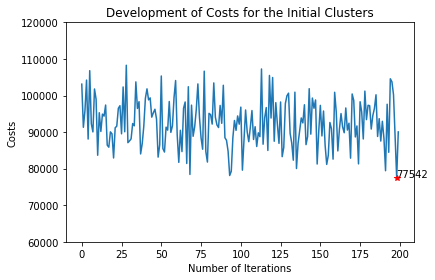

In [22]:
# plot cluster initialization line graph

initial_cost_list = [final_evaluation(x,y) for x, y in zip(list_clusters, list_cost)]
plt.plot(initial_cost_list)

# get minimum of genetic and set marker
best_initial_cluster = min(initial_cost_list)
time = initial_cost_list.index(best_initial_cluster)

plt.plot(time, best_initial_cluster, 'r*')
plt.annotate(str(best_initial_cluster), xy = (time, best_initial_cluster))

# Set limits of y-axis
plt.ylim(bottom=60000, top=120000)

# label axis
plt.xlabel('Number of Iterations')
plt.ylabel('Costs')

# set title
plt.title('Development of Costs for the Initial Clusters')
plt.tight_layout()

plt.savefig('initial_clusters.png', dpi=600)

#### 4.2 Genetic Algorithm for Route Optimization

In [23]:
# take the best initial clusters and optimize it with the genetic algorithm
all_populations = create_permutations(starting_best, population_size)
cost_list = best_cost_list
best = all_populations

# store all solutions in one list for plotting
solution_list = []

for i in range(100):

    mating_pool = tournament_selection(all_populations,mating_pool_size,population_size, cost_list)
    new_generation = recombine_uniform_order_based_crossover(population_size,mating_pool,crossover_probability, mating_pool_size)
    mutation = mutate_swap(new_generation, mutation_probability)
    all_populations = mutation
    solution_list.append(final_evaluation(choose_best(all_populations, cost_list,population_size), cost_list))
    print("i", i, final_evaluation(choose_best(all_populations, cost_list,population_size), cost_list))
    if (final_evaluation(choose_best(all_populations, cost_list,population_size), cost_list)) < final_evaluation(choose_best(best, cost_list,population_size), cost_list):
        best = all_populations
            

last_solution = choose_best(all_populations, cost_list,population_size)
final_solution = choose_best(best, cost_list,population_size)

print("last cost:", final_evaluation(last_solution, cost_list))
print("best cost:", final_evaluation(final_solution, cost_list))
print("car types used: ", best_cars)
print("Final route: ",choose_best(best, cost_list,population_size))

i 0 141334
i 1 132225
i 2 133241
i 3 130580
i 4 128885
i 5 130257
i 6 122718
i 7 123784
i 8 125175
i 9 123474
i 10 128954
i 11 128954
i 12 119492
i 13 126174
i 14 122026
i 15 121047
i 16 121408
i 17 116935
i 18 114878
i 19 121152
i 20 120766
i 21 118928
i 22 117708
i 23 117390
i 24 116682
i 25 114821
i 26 114281
i 27 112511
i 28 110681
i 29 110601
i 30 110655
i 31 110330
i 32 105779
i 33 106759
i 34 106968
i 35 108828
i 36 107422
i 37 104890
i 38 105020
i 39 105020
i 40 105020
i 41 105020
i 42 105020
i 43 105080
i 44 105080
i 45 104990
i 46 104990
i 47 105110
i 48 105530
i 49 105470
i 50 104630
i 51 104570
i 52 104630
i 53 102590
i 54 104510
i 55 103918
i 56 103790
i 57 103768
i 58 104398
i 59 103677
i 60 103618
i 61 103618
i 62 103618
i 63 103108
i 64 103018
i 65 103018
i 66 102988
i 67 102754
i 68 101824
i 69 101824
i 70 99784
i 71 101224
i 72 101734
i 73 101734
i 74 101734
i 75 101734
i 76 101704
i 77 101734
i 78 101704
i 79 101464
i 80 101704
i 81 101734
i 82 100796
i 83 100796
i 8

## 5. Evaluation

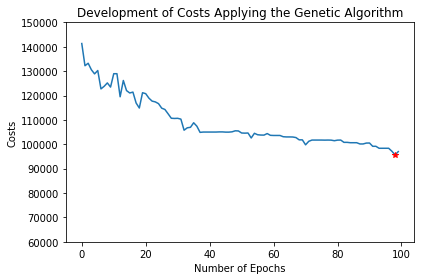

In [24]:
# plot line graph
plt.plot(solution_list)

# get minimum of genetic and set marker
val, idx = min((val, idx) for (idx, val) in enumerate(solution_list))
plt.plot(idx,val,'r*')

# Set limits of y-axis
plt.ylim(bottom=60000,top=150000)

# label axis
plt.xlabel('Number of Epochs')
plt.ylabel('Costs')
#plt.annotate(str(val), xy = (idx,val)) 
# set title
plt.title('Development of Costs Applying the Genetic Algorithm')

plt.tight_layout()

plt.savefig('pop20_mat8_cross07_mut01_heur10000_gen1000.png', dpi=600)